In [ ]:
legi: 20-945-796

# SLT-CE-4: Constant Shift Embedding

## Task

Many real-world phenomena are described by pairwise proximity data, modeling interactions between the entities of the system. This in contrast to the more common situation where each data sample is given as a feature vector. Even though the clustering of the proximity data may be performed directly on the data matrix, there are some advantatages of  embedding the data into a vector space. For example, it enables the use of some standard preprocessing techniques such as denoising or dimensionality reduction. In this coding exercise, we will explore the tecnhique called _Constant Shift Embedding_ for restating pairwise clustering problems in vector spaces [1] while preserving the cluster structure. We will apply the algorithm described in [1] to cluster the groups of research community members based on the email correspondence matrix. The data and its description is given in [2].

### References 

[1] [Optimal cluster preserving embedding of nonmetric proximity data](https://ieeexplore.ieee.org/document/1251147)

[2] [email-Eu-core](https://snap.stanford.edu/data/email-Eu-core.html)

 <h2 style="background-color:#f0b375;"> Setup </h2>

We start by importing necessary python packages.

In [2]:
import numpy as np
import sklearn as skl
import matplotlib.pylab as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans

import scipy.linalg as la
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

# Fix randoom seed for reproducibility
np.random.seed(42)

The number of nodes is hardcoded for simplicity (taken from [2]):

In [3]:
NUM_NODES = 1005

We load the file which contains the list of interactions between the community members (nodes). Our data matrix represents an undirected graph which connects two nodes if there was at least one email sent between the two corresponding community members. Thus our data matrix is essentially an adjacency matrix.

In [4]:
# initialize data matrix which will be an adjacency matrix
DATA = np.zeros((NUM_NODES, NUM_NODES))

# fill out the symmetric adjacency matrix
with open("email-Eu-core.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        DATA[pair[0], pair[1]] = 1
        DATA[pair[1], pair[0]] = 1

Note that DATA specifies an adjacency matrix of the email graph. It's not claimed to be a proper dissimilarity matrix required by CSE algorithm. So, you are allowed to perform any manipulations to construct a suitable (dis-)similarity matrix for the further analysis.

Next we define a class which contains main functionalities - TO BE IMPLEMENTED.

In [5]:
import scipy.sparse as sparse
import scipy.sparse.csgraph as sparsegraph

class ConstantShiftEmbedding(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for Constant Shift Embedding (CSE)
    
    Attributes:
        PMAT (np.ndarray): Proximity matrix used for calculating the embeddings.
        S (np.ndarray): Similarity matrix.
        D (np.ndarray): Dissimilarity matrix.
        
    """
    
    def __init__(self):
        #TODO: remove params not used outside of this function
        self.PMAT = None
        self.S_c = None # centered Similarity matrix
        self.S_shifted = None # shifted Similarity matrix
        self.D_shifted = None # shifted Dissimilarity matrix
        # Add/change parameters, if necessary.
    
    def fit(self, PMAT):
        """ Calculate similarity/dissimiliarity matrix and all
        the necessary variables for calculating the embeddings.
        
        Args:
            PMAT (np.ndarray): proximity matrix
        """
        # Save data
        self.PMAT = PMAT
        n = PMAT.shape[0] 
        
        # computes symmetrized D
        D = sparsegraph.shortest_path(sparse.csr_matrix(PMAT.copy()), directed=True, unweighted=True)
        D[D == np.inf] = 12
        
        #np.fill_diagonal(D, 0)  # model assumption: self-dissimilarity=0
        D_sym = 0.5*(D + D.T) # Symmetrized Dissimilarity matrix
        
        # computes D_c and S_c
        e_nn = np.ones((n,n))
        Q = np.identity(n) - (1/n)*e_nn
        D_c = Q.dot(D_sym).dot(Q)  # centered Dissimilarity matrix
        self.S_c = -(1/2)*D_c  
        
        #print(sum(self.S_c[i,3] for i in range(n)))
        
        # computes S_s and D_s
        eigenvalues_S_c = np.linalg.eigvalsh(self.S_c)
        lamda_n = eigenvalues_S_c[0]
        self.D_shifted = D_sym - 2*lamda_n*(e_nn - np.identity(n))
        
        
    def get_embedded_vectors(self, p):
        """Return embeddings
        
        Args:
            p (np.ndarray): cut-off value in eigenspectrum
        
        Returns:
            Xp (np.ndarray): embedded vectors
        
        """
        n = self.PMAT.shape[0] 
        
        # computes S_c_shifted
        e_nn = np.ones((n,n))
        Q = np.identity(n) - (1/n)*e_nn
        S_c_shifted = -0.5*Q.dot(self.D_shifted).dot(Q)
        
        # computes eigendecomposition and map matrix
        eigenvalues, V_n = np.linalg.eigh(S_c_shifted)
        eigenvalues = eigenvalues[::-1] # setting ascending order
        V_n = V_n[:,::-1] # inverting vectors indexes
        
        # approximate given p
        Lambda_p = np.diag(eigenvalues[:p]**(1/2))
        V_p = V_n[:,:p]
        #print(Lambda_p.shape)
        #print(V_p.shape)
        
        X_p = V_p.dot(Lambda_p)
        return X_p


<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">Describe briefly and consicely the model given in [1]. Explain the main steps of _Constant Shift Embedding_ algorithm. See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.</p>

- **Constant Shift Embedding**: 
<br>
Taking as input a dissimilarity matrix D, it computes the following steps:

Symmetrization:
>$D_{sym} = \frac{1}{2}(D + D^T)$<br>

Centralization:
>$D_c = QD_{sym}Q$ with $Q=I_n - \frac{1}{n}e_ne_n^T$<br>
>$S_c = -\frac{1}{2}D_c$<br>

Minimal Shift(Theorem 2 in [1]): 
>$D_{shifted} = D_{sym} - 2\lambda_n(S_c)(e_ne_n^T - I_n)$ 


Afterwards, in order to reconstract the embedding vectors it does as follows:

$S_{shifted, c} = QD_{shifted}Q$ <br>

then computes the eigenvalue decomposition $V\Lambda V^T$ of $S_{shifted, c}$
and assigns $X_p = V_p\Lambda^{1/2}_p$, where p is the eigen-spectrum cut-off value.






<p style="background-color:#adebad;">
    Implement Constant Shift Embedding. We start off by making an instance of the corresponding class.
</p>    

In [6]:
CSE = ConstantShiftEmbedding()

<p style="background-color:#adebad;">
    Fit the data matrix. _fit(...)_ method computes necessary variables which can be later on used to produce embeddings [1].
</p>    

In [7]:
CSE.fit(DATA)

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    Next, try to find approximately optimal $p = p^∗$, a cut-off value which removes noise from the data. To do that, produce an eigen-spectrum plot as shown in [1] figure 4a and briefly explain your choice of $p^∗$.
</p>

In [8]:
## Compute eigen-spectrum
eigenvalues_S_c = np.linalg.eigvalsh(CSE.S_c)
#print(eigenvalues_S_c)

In [10]:
## Determine a good cut-off value (and write some lines to explain your choice)
p_opt = 25 ## change accordingly
print("Chosen cut-off value is: ", p_opt)

# After the first 25 leading eigenvalues, the values start to decrease at a slower rate, meaning that the
# relative dimensions are very likely not dominating directions of the embedding space. Moreover, the exact value
# has been selected by experimenting taking into account the plots of the following section for different values of p_opt.

Chosen cut-off value is:  25


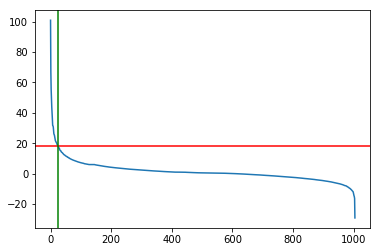

In [11]:
## Plot spectrum and indicate the cut-off value on the spectrum
plt.plot(eigenvalues_S_c[::-1])
plt.axhline(y=eigenvalues_S_c[-p_opt], color='r', linestyle='-')
plt.axvline(x=p_opt, color='g', linestyle='-')
plt.show()

<h2 style="background-color:#f0b375;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
    Plot the distance matrices both for the denoised ($p = p^*$ -- from the previous step) and the original versions as shown in figure 5 in [1]. Note that the distance matrix is a matrix with pairwise distances between every two points from the dataset ($d_{ij} = dist(x_i, x_j)$).<br>
    Perform K-MEANS algorithm for varying number of clusters K on the embedded vectors derrived from CSE. You may use the sklearn implementation of K-MEANS. To make the aforementioned plots meaningful, sort the nodes according to the cluster belongings for every number of clusters K (see the figure 5). For now, there is no need to include the actual ground truth labels given in [2].
</p>

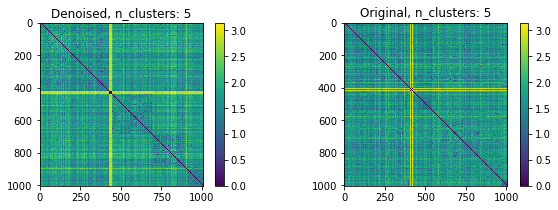

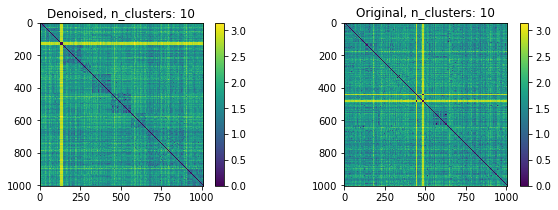

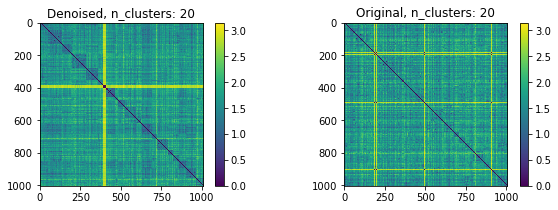

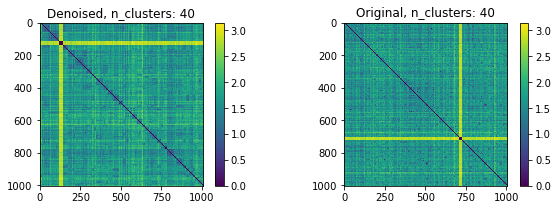

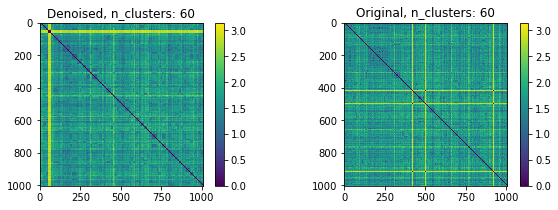

In [13]:
import scipy.spatial as spt
## Distance matrices
X_p = CSE.get_embedded_vectors(p_opt)
X_p_original = CSE.get_embedded_vectors(DATA.shape[0]-1)
for n_clusters in [5,10,20,40,60]:
    fig = plt.figure(figsize=(10,3))
    ax1 = fig.add_subplot(1,2,1)
    dist = spt.distance.squareform(spt.distance.pdist(X_p))
    assignments = skl.cluster.KMeans(n_clusters).fit_predict(X_p)
    indexes = np.argsort(assignments)
    img1 = ax1.imshow(dist[indexes][:,indexes])
    ax1.title.set_text('Denoised, n_clusters: {}'.format(n_clusters))
    fig.colorbar(img1, ax=ax1)
    
    ax2 = fig.add_subplot(1,2,2)
    dist_original = spt.distance.squareform(spt.distance.pdist(X_p_original))
    assignments_original = skl.cluster.KMeans(n_clusters).fit_predict(X_p_original)
    indexes_original = np.argsort(assignments_original)
    img2 = ax2.imshow(dist[indexes_original][:,indexes_original])
    ax2.title.set_text('Original, n_clusters: {}'.format(n_clusters))
    fig.colorbar(img2, ax=ax2)
    

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    Producing 2D and 3D embeddings allows us to nicely visualize generated clusters. Now calculate the embeddings for p = 2 (2D case) and p = 3 (3D case) and plot clusterings for a few values of K.  Alternatively, you could use $p = p^*$ for more gentle denoising, cluster the denoised embeddings and only then apply a dimensionality reduction technique to get a plot in 2,3-dimensional space. You could use PCA, LLE, t-SNE etc. figure out what works for you. As an example see figure 6 (b) from [1] where CSE is combined with PCA.
</p>

In [ ]:
## Get embeddings, run K-MEANS and generate plots

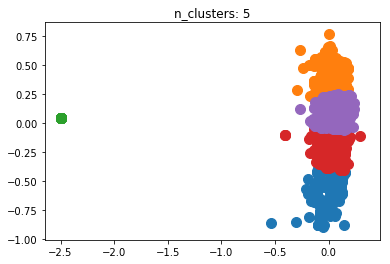

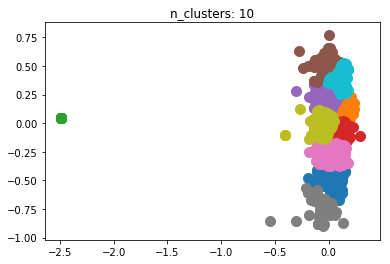

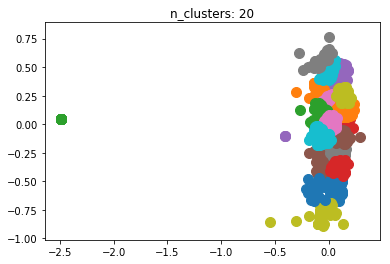

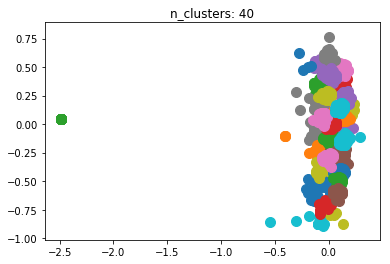

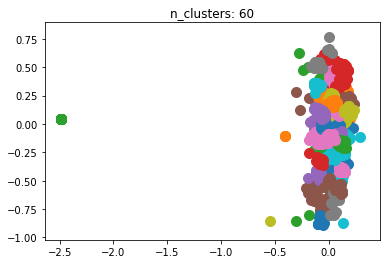

In [14]:
## p = 2
X_p_2 = CSE.get_embedded_vectors(2)
for k in [5,10,20,40,60]:
    assignments = skl.cluster.KMeans(k).fit_predict(X_p_2)
    fig, ax = plt.subplots()
    ax.title.set_text('n_clusters: {}'.format(k))
    for a in np.unique(assignments):
        ix = np.where(assignments == a)
        ax.scatter(X_p_2[ix, 0], X_p_2[ix, 1], label=a, s = 100)
    plt.show()


(1005, 3)


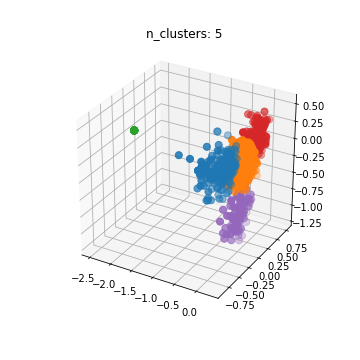

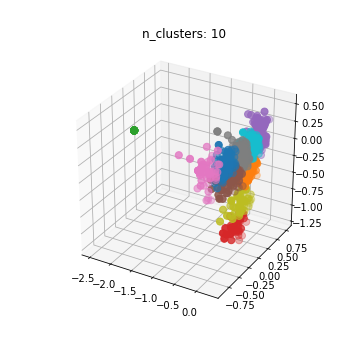

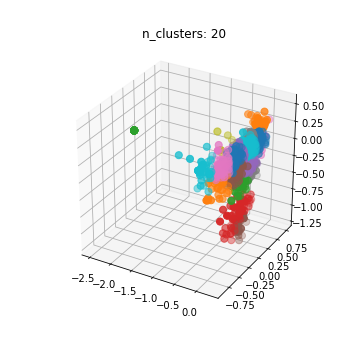

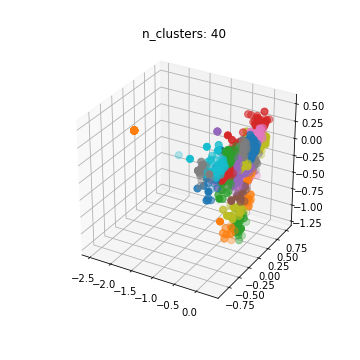

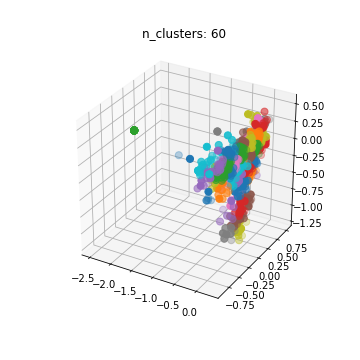

In [15]:
## p = 3
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
X_p_3 = CSE.get_embedded_vectors(3)
print(X_p_3.shape)
for k in [5,10,20,40,60]:
    assignments = skl.cluster.KMeans(k).fit_predict(X_p_3)
    fig = plt.figure(figsize=(5,5))
    ax = plt.axes(projection="3d")
    ax.title.set_text('n_clusters: {}'.format(k))
    for a in np.unique(assignments):
        ix = np.where(assignments == a)
        ax.scatter3D(X_p_3[ix, 0], X_p_3[ix, 1], X_p_3[ix, 2], label=a, s=50, marker='o')

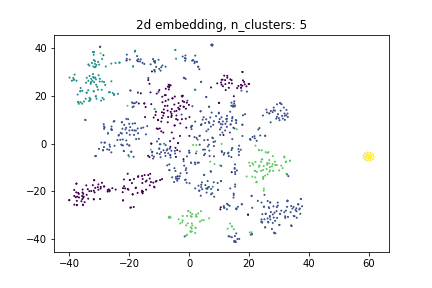

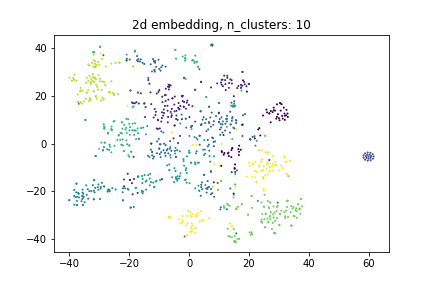

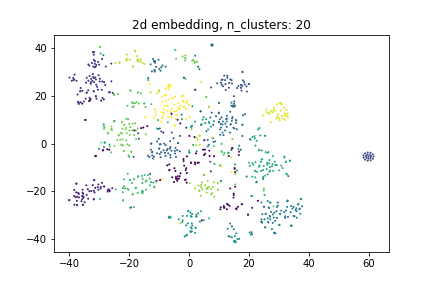

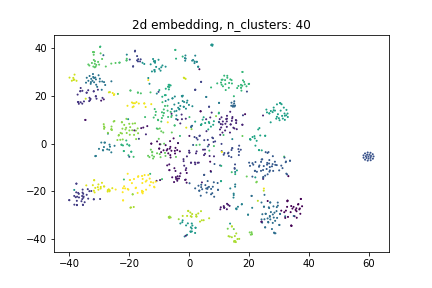

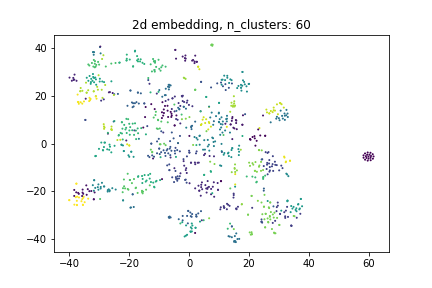

In [103]:
## choose p > 3, for example, p = p_opt, to compute CSE embeddings 
## First, cluster the computed p-dimentional embeddings and then project them onto 2-dimensional space 
## for visualization using PCA, LL, t-SNE or something else
from sklearn.manifold import TSNE

X_p_opt = CSE.get_embedded_vectors(p_opt)
for k in [5,10,20,40,60]:
    assignments = skl.cluster.KMeans(k).fit_predict(X_p_opt)
    tsne = TSNE(n_components = 2, random_state=42)
    tsne_emb= tsne.fit_transform(X_p_opt)
    plt.scatter(tsne_emb[:,0], tsne_emb[:,1], c=assignments, s=1, cmap='viridis')
    plt.title("2d embedding, n_clusters: {}".format(k))
    plt.show()

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Finally, to evaluate the quality of the above derived clusters, let's compare our predictions with the ground truth. We will use the actual member-institution mappings given in [2]. You can reuse code from the previous coding exercises to align the cluster labels with the ground truth.
</p>

In [104]:
# Initialize community members affiliation array
AFFILIATIONS = np.zeros((NUM_NODES, ))

# Fill out the affiliation array
with open("email-Eu-core-department-labels.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        AFFILIATIONS[pair[0]] = pair[1]

# Number of organizations is 
print("The true number of clusters (departments) is: ",len(np.unique(AFFILIATIONS)))


# method needed to align clustering labels with ground truth labels
def postprocess(y_pred, y_truth):
    
    labels_map = np.argmax(skl.metrics.cluster.contingency_matrix(assignments, AFFILIATIONS), axis=1)
    y_new = []
    for y in y_pred:
        y_new.append(labels_map[y])
        
    return np.array(y_new)


The true number of clusters (departments) is:  42


<p style="background-color:#adebad;">
Visually or quantitatively, in a clever and convincing way, show that the K-MEANS generated clusters overlap with the ground truth clusters (member affiliations). How can we measure the overlapping of the predicted and true clusters?
</p>

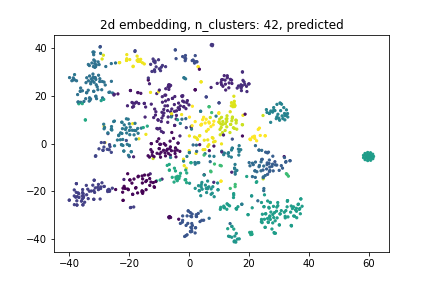

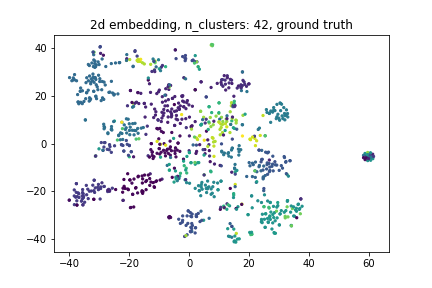

In [105]:
## Here you can provide plots and calculations
X_p_f = CSE.get_embedded_vectors(p_opt)
assignments = skl.cluster.KMeans(42).fit_predict(X_p_f)
assignments_processed = postprocess(assignments, AFFILIATIONS)
tsne = TSNE(n_components = 2, random_state=42)
tsne_emb= tsne.fit_transform(X_p_opt)
plt.scatter(tsne_emb[:,0], tsne_emb[:,1], c=assignments_processed, s=5, cmap='viridis')
plt.title("2d embedding, n_clusters: 42, predicted")
plt.show()

plt.scatter(tsne_emb[:,0], tsne_emb[:,1], c=AFFILIATIONS, s=5, cmap='viridis')
plt.title("2d embedding, n_clusters: 42, ground truth")
plt.show()

In [108]:
acc = skl.metrics.accuracy_score(AFFILIATIONS, assignments_processed)
print('Accuracy: ', acc)
rand = skl.metrics.adjusted_rand_score(AFFILIATIONS, assignments_processed)
print('Adjusted Rand Index: ', rand)
inf = skl.metrics.normalized_mutual_info_score(AFFILIATIONS, assignments_processed)
print('Mutual Information Based Score: ', inf)

Accuracy:  0.6059701492537314
Adjusted Rand Index:  0.46704012656078175
Mutual Information Based Score:  0.6140286839495834


/Users/riccardodesanti/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Please, write here your explanations, observation and thoughts about results of the experiments above.

I believe that different dissimilarity measures may be able to improve the performance of the agorithm. In particular, I could not find a very principle way to justify the use of the shortest distance metric.

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.